In [1]:
from nustar_gen.radial_profile import find_source, make_radial_profile, optimize_radius_snr
from nustar_gen.wrappers import make_image

from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import numpy as np

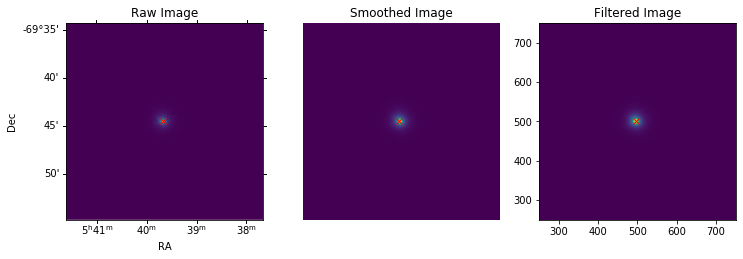

In [2]:
infile = 'example_data/30001039002/event_cl/nu30001039002A01_cl.evt'
full_range = make_image(infile, elow = 3, ehigh = 80, clobber=True)
coordinates = find_source(full_range, show_image = True, filt_range=3)

In [3]:
# Get the WCS header and convert the pixel coordinates into an RA/Dec object
hdu = fits.open(full_range, uint=True)[0]
wcs = WCS(hdu.header)

# The "flip" is necessary to go to [X, Y] ordering from native [Y, X] ordering, which wcs seems to require
world = wcs.all_pix2world(np.flip(coordinates), 0)
ra = world[0][0]
dec = world[0][1]
target = SkyCoord(ra, dec, unit='deg', frame='fk5')
print(target)
obj_j2000 = SkyCoord(hdu.header['RA_OBJ'], hdu.header['DEC_OBJ'], unit = 'deg', frame ='fk5')

# How far are we from the J2000 coordinates? If <15 arcsec, all is okay
sep = target.separation(obj_j2000)
print(sep)


<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (84.91873214, -69.74221565)>
0d00m09.3596s


In [4]:
# Now the radial image parts.

# Make the radial image for the full energy range (or whatever is the best SNR)
full_range = make_image(infile, elow = 3, ehigh = 80, clobber=True)
rind, rad_profile, radial_err, psf_profile = make_radial_profile(full_range, show_image=False,
                                                                 coordinates = coordinates)

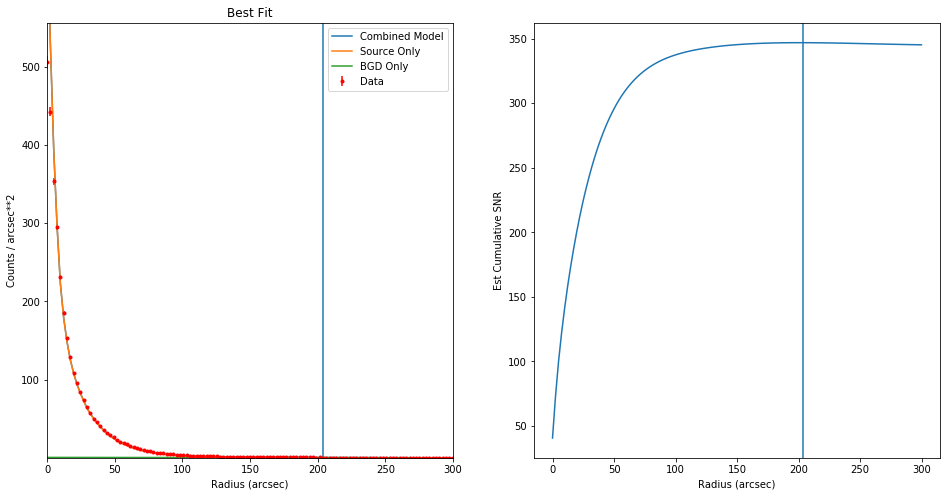

Radius of peak SNR for 3 to 20 keV: 204.02291088


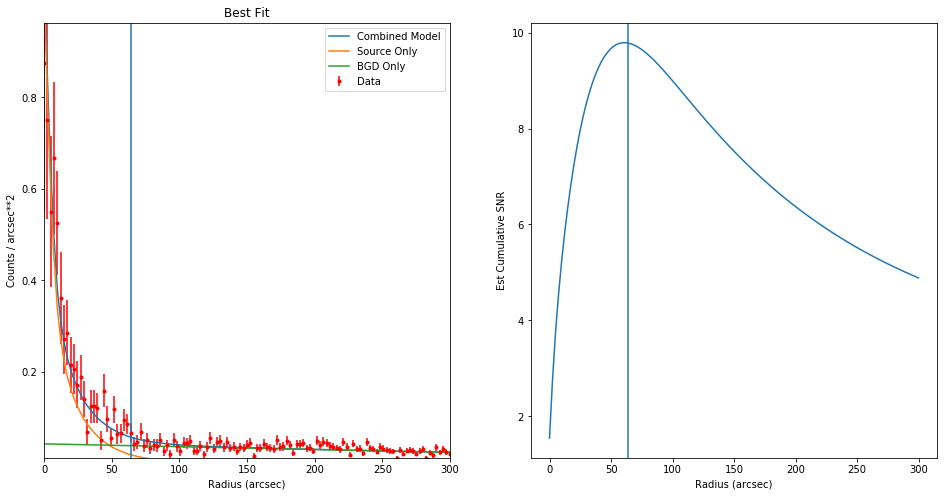

Radius of peak SNR for 20 to 30 keV: 63.910791360000005


/Users/bwgref/miniconda3/envs/nustar/lib/python3.7/site-packages/scipy/optimize/minpack.py:729: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/bwgref/miniconda3/envs/nustar/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


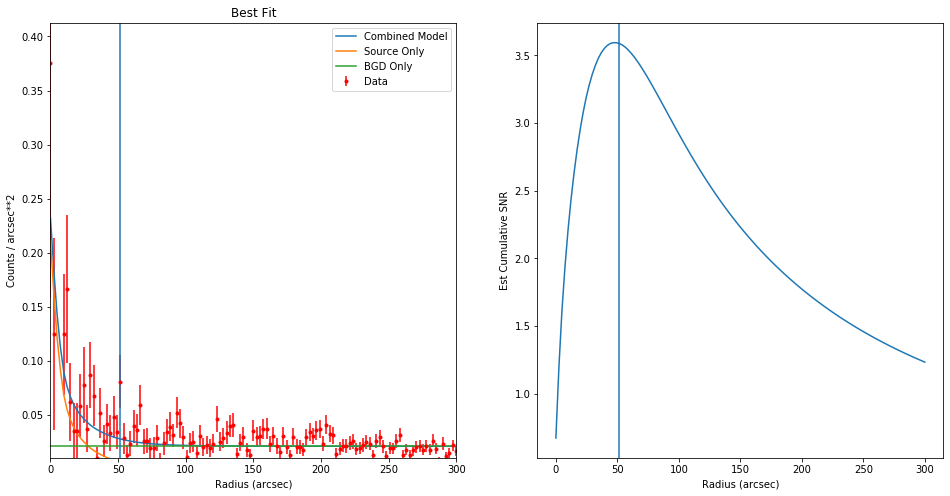

Radius of peak SNR for 30 to 40 keV: 51.62025456


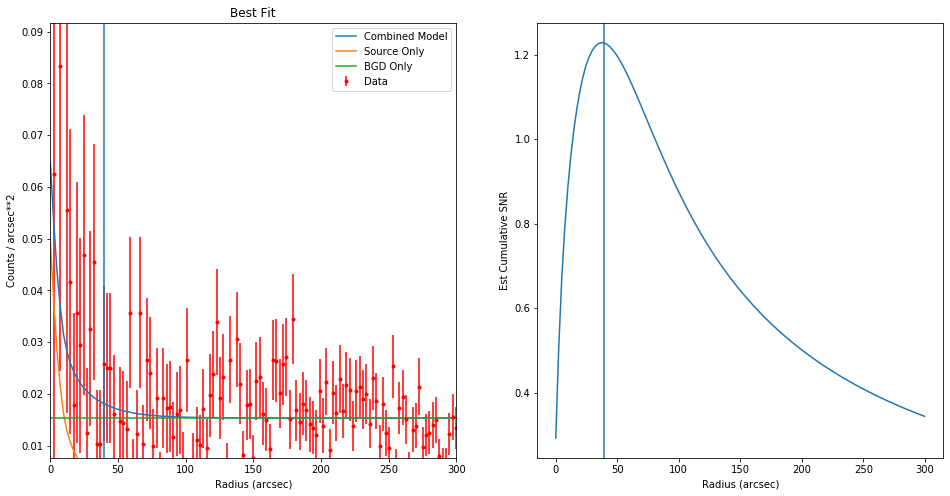

Radius of peak SNR for 40 to 50 keV: 39.32971776


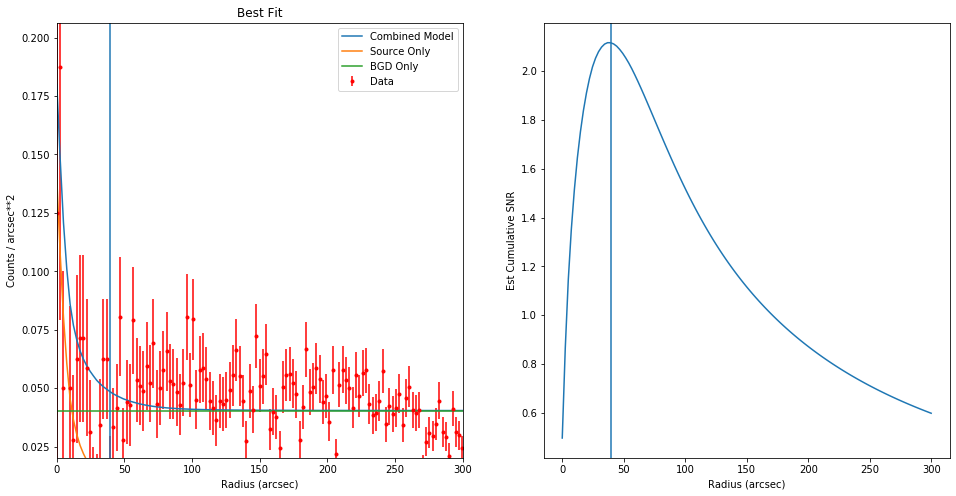

Radius of peak SNR for 50 to 80 keV: 39.32971776


In [5]:
# Pick energy ranges that you want to check.

# Note that this formalism breaks down when the source isn't detected, so use your best judgement here.

# Below should be used as a "best guess" when choosing a radius for spectral extraction.

# For the 3-20 keV case, the source dominates out the edge of the FoV (and the assumptoons about the PSF
# start to break down in the fit).

# This a soft source (LMC X-1), so for 20-30 keV we already see that we need to restrict the radius that we
# use so that we're not just adding noise to the spectrum.

pairs = [[3, 20], [20, 30], [30, 40], [40, 50], [50, 80]]
coordinates = find_source(full_range, show_image = False)
for pair in pairs:
    test_file = make_image(infile, elow = pair[0], ehigh = pair[1], clobber=True)
    rind, rad_profile, radial_err, psf_profile = make_radial_profile(test_file, show_image=False,
                                                                     coordinates = coordinates)
    rlimit = optimize_radius_snr(rind, rad_profile, radial_err, psf_profile, show=True)
    print('Radius of peak SNR for {} to {} keV: {}'.format(
            pair[0], pair[1], rlimit))